# Speed distributions $f(v)$ for each shard as well as our composite model


In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#######

# v range
n = 100
v = linspace(0,850.0,n)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*233.0/sqrt(2.0)
day = 67.0 

# Load shards
df = pandas.read_csv('../data/FitShards.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
Psun = df.Psun
weights = pops*norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
weights /= sum(weights)


# Speed distributions
fv_Iso = SpeedDist_Isotropic(v,day) # Round halo
fv_Saus = SpeedDist_Triaxial(v,day,sig_beta) # Sausage
fv_Iso_gal = SpeedDist_Triaxial(v,day,sig_iso,GalFrame=True) # Galactic frame Halo
fv_Saus_gal = SpeedDist_Triaxial(v,day,sig_beta,GalFrame=True) # Galactic frame Sausage

fv = zeros(shape=(nshards,n))
fv_gal = zeros(shape=(nshards,n))
for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fv[i,:] = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s)
    fv_gal[i,:] = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GalFrame=True)
    sigr = sig_s[0]
    sigphi = sig_s[1]
    sigz = sig_s[2]
    beta = 1.0-(sigr**2.0+sigz**2.0)/(2*sigr**2.0)
df

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


NameError: name 'pops' is not defined

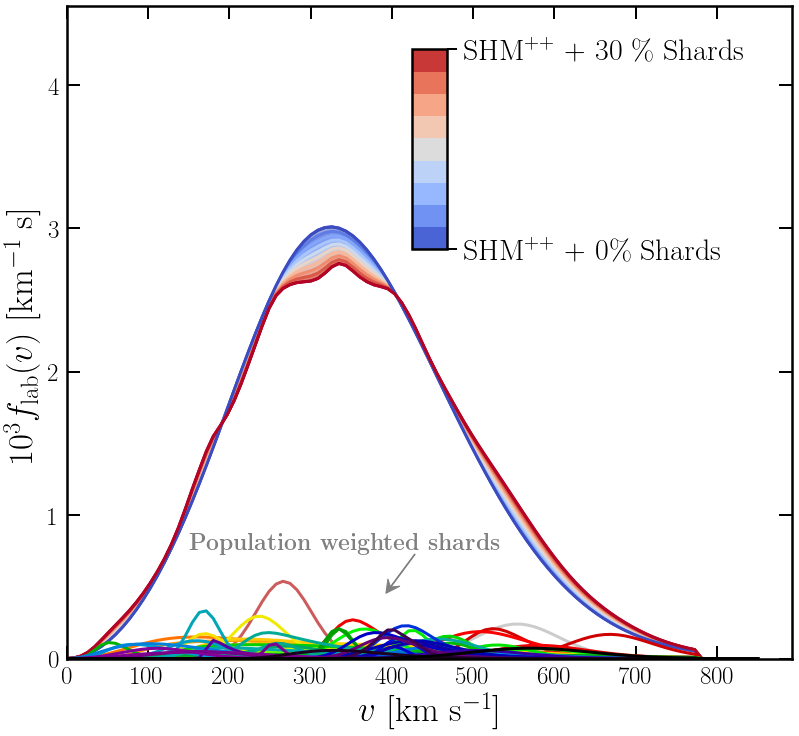

In [26]:
# Figure setup
fig,ax = MySquarePlot(r"$v$ [km s$^{-1}$]",r"$10^3 f_{\rm lab}(v)$ [km$^{-1}$ s]")


# Smooth component
eta_saus = 0.2
fv0 = (1-eta_saus)*fv_Iso + eta_saus*fv_Saus


# Shards with varying xi
n_xi = 10
xi_max = 0.3
xi_vals = linspace(0,xi_max,n_xi)
col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
y2 = 1e3*(xi_vals[-1]*sum(fv,0)+(1.0-xi_vals[-1])*fv0)
for i in range(0,n_xi):
    plt.fill_between(v,1e3*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv0),y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(v,1e3*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv0),'-',color=col[i,:],linewidth=3)
    
# Range
cbar_max = r'SHM$^{++}$ + 30 \% Shards'
cbar_min = r'SHM$^{++}$ + 0\% Shards'
plt.plot(v,1e3*fv0,'-',color=col[0,:],linewidth=3)
plt.plot(v,y2,'-',color=col[-1,:],linewidth=3)

# Plot individual streams
colstrs = flipud(cm.nipy_spectral(linspace(0.0,1.0,nshards)))
for i in range(0,nshards):
    #plt.fill_between(v,1e3*fv[i,:],color=colstrs[i,:],linewidth=3,alpha=0.7,label=names[i])
    plt.plot(v,1e3*fv[i,:],color=colstrs[i,:],linewidth=3,label=names[i])
#leg = plt.legend(loc='upper left',fontsize=10,edgecolor='k',ncol=4)
#leg.get_frame().set_linewidth(1.5)
 
    
# Plot fiddling
ax.set_xlim(left=0)
ax.set_ylim(bottom=0,top=max(1e3*fv_Iso)*1.6)
plt.text(150,0.75,r'\bf {Population weighted shards}',fontsize=23,color='gray')
plt.arrow(0.48, 0.16, -0.04, -0.06, transform=ax.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')



# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-190, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)


# Save figure
plt.show()
pltname = 'Shards_fv'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')